In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Hcomplex(z):# computes the hue corresponding to the complex number z
    H = np.angle(z) / (2*np.pi) + 1
    return np.mod(H, 1)


In [97]:
def Mahler(r,r_prime,phi, omega_0):
    dot =  np.einsum("ijk,i->jk",r, r_prime)
    if np.abs(np.exp(phi) - 1) < 1e-8 or np.abs(np.exp(phi) + 1) < 1e-8:
        return 0.0
    elif np.abs(np.exp(phi) - 1j) < 1e-8 or np.abs(np.exp(phi) + 1j) < 1e-8:
        # print(f"Confocal part only {phi=:.2f}  {np.sinh(phi)=:.2f}")
        return np.exp(phi)/(2*np.pi*np.sinh(phi)) * np.exp(2*dot/(omega_0**2*np.sinh(phi)))
    else:
        # print(f"Full green's function {phi=:.2f} {np.exp(phi)=:.2f}")
        return np.exp(phi)/(2*np.pi*np.sinh(phi)) * np.exp(-(np.square(np.linalg.norm(r, axis=0)) + np.square(np.linalg.norm(r_prime, axis=0)))/(omega_0**2*np.tanh(phi)) + 2*dot/(omega_0**2*np.sinh(phi)))

def G_eta(r,r_prime,phi, omega_0, N, eta):
    if r_prime.shape != (2,):
        print("R_prime wrong shape: ", r_prime.shape)
        raise
    if len(r.shape) != 3:
        print("r has the wrong number of indeces: ", len(r.shape))
        raise
    if r.shape[1] != r.shape[2]:
        print("r is not the right shape: ", r.shape)
        raise
    sumOfG = np.zeros((r.shape[1],r.shape[2]), dtype=np.complex128)
    for s in range(N):
        sumOfG += np.exp(-2j*np.pi*s*eta/N)*Mahler(r, r_prime, phi-2j*np.pi*s/N, omega_0)
    return sumOfG/N

def D_plus(r, r_prime, omega_0, M, N):
    return 2*np.real(G_eta(r,r_prime, -1j*np.pi*M/N, omega_0, N, 0.0))

def G_script(r, r_prime, omega_0, epsilon, kappa):
    return 0.0

def plot_wave_centers(source, M, N):
    plt.scatter(source[0],source[1],color='red')
    for n in range(1,N):
        plt.scatter(source[0]/np.cos(n*np.pi*M/N), source[1]/np.cos(n*np.pi*M/N), color='blue')

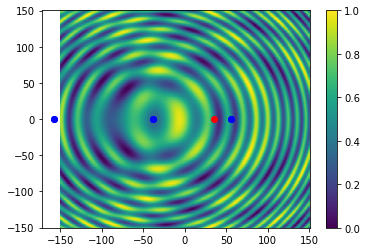

In [18]:
x = np.linspace(-150.0, 150.0, 500)
y = np.linspace(-150.0, 150.0, 500)
X,Y = np.meshgrid(x,y)
R = np.array([X,Y])

M = 4
N = 7
omega_0 = 35.0
source = [35.0,0.0]
# E = G(R, [1.0,0.0], -1j*np.pi/2, 1.0)

plt.pcolor(X, Y, D_plus(R, source,omega_0,M,N))
plot_wave_centers(source, M, N)
plt.colorbar()
plt.show()

In [32]:
def findJijForPoints(listOfPoints, omega_0, M, N, eta):
    num_points = listOfPoints.shape[1]
    J = np.zeros((num_points,num_points))
    for i in range(num_points):
        J[i,:] = D_plus(np.array([[listOfPoints[0]], [listOfPoints[1]]]),listOfPoints[:,i], omega_0, M, N)

    return J

In [34]:
def generateGaussianPointsList(num_of_points, width, center=(0,0)):
    xCoords = np.random.normal(center[0], width, num_of_points)
    yCoords = np.random.normal(center[1], width, num_of_points)
    return np.array([xCoords, yCoords])

def generateLaticePointsList(num_point_x, num_points_y, top_left_cordinate, x_lattice_spacing, y_lattice_spacing):
    points = np.zeros((2, num_point_x*num_points_y))
    for i in range(0,num_point_x):
        for j in range(0, num_points_y):
            points[0, num_points_y*i + j] = top_left_cordinate[0] + i*x_lattice_spacing
            points[1, num_points_y*i + j] = top_left_cordinate[1] + j*y_lattice_spacing
    return points

In [90]:
def optimizeJij(Jij):
    if len(Jij.shape) != 2:
        return -1
    if Jij.shape[0] != Jij.shape[1]:
        return -1
    n = Jij.shape[0]
    best_vec = None
    curr_vec = np.zeros(n)
    minimum_energy = np.inf
    for i in range(0, 2**n):
        # print(i)
        for j in range(0,n):
            if i % 2**(j+1) >= 2**j:
                curr_vec[j] = 1
            else:
                curr_vec[j] = -1
        Energy = np.dot(curr_vec, np.dot(Jij, curr_vec))
        # print(curr_vec, Energy)
        if minimum_energy > Energy:
            best_vec = np.copy(curr_vec)
            minimum_energy = Energy
        # print("Best: ", best_vec, minimum_energy)
    if best_vec is None:
        return -1

    return (best_vec, minimum_energy)

In [95]:
def findTotalGreensFunction(r, points, spins, omega_0, M, N):
    if len(points) != len(spins):
        return -1
    n = len(points)
    G_tot = np.zeros(r.shape)
    for i in range(0,n):
        G_tot += spins[i]*D_plus(r, points[i], omega_0, M, N)
    return G_tot


In [98]:
points = generateLaticePointsList(5,1,[0,0],10.0,10.0)
Jij = findJijForPoints(points, 35.0, 1, 2, 0.0)
spins = optimizeJij(Jij)
plt.pcolor(X, Y, findTotalGreensFunction(R, points, spins,omega_0,1,2))
plt.colorbar()
plt.show()

r is not the right shape:  (2, 1, 5)


RuntimeError: No active exception to reraise

In [99]:
R

array([[[-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ],
        [-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ],
        [-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ],
        ...,
        [-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ],
        [-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ],
        [-150.        , -149.3987976 , -148.79759519, ...,
          148.79759519,  149.3987976 ,  150.        ]],

       [[-150.        , -150.        , -150.        , ...,
         -150.        , -150.        , -150.        ],
        [-149.3987976 , -149.3987976 , -149.3987976 , ...,
         -149.3987976 , -149.3987976 , -149.3987976 ],
        [-148.79759519, -148.79759519, -148.79759519, ...,
         -148.

In [ ]:
for width in [0.1, 0.5, 1.0, 1.5, 2.0, 10.0, 50.0, 100.0]:
    points = generateGaussianPointsList(1000, width)
    J = findJijForPoints(points, 1.0, 4, 7, 0)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(J.reshape(1000000), bins=50)
    ax.set_title(f"Weights for {width} omega")
    fig.savefig(f"weights{width}.png")
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.hist(np.linalg.eigvals(J),bins=50)
    ax.set_title(f"Eigenvalues for {width} omega")
    fig.savefig(f"eigenvals{width}.png")